# Numerical simulation (annealing time)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from QUBO import QMatrix, QUBOSolution
from qutip import *
import networkx as nx
import dwave_networkx as dnx
import itertools
import minorminer as mm
from scipy import interpolate
from itertools import combinations
from collections import defaultdict
from graphs import DrawSolution, NetworkToFile, FileToNetwork
from graphs import DrawNetwork, GraphPartitioning, RandomGraphGenerator

We want to simulate the annealing path 

$$H(s) = -\frac{A(s)}{2} H_I + \frac{B(s)}{2} H_{P}$$

with 

$$H_I = \sum_i \sigma_i^x$$

and 

$$H_{P} = \sum_i h_i \sigma_i^z + \sum_{i<j} J_{ij} \sigma_i^z \sigma_j^z$$

Since we have developed most of the examples using the QUBO formulation, we will stick to that. Therefore, the problem Hamiltonian will be given by 

$$H_p(x) = \sum_i Q_{ii} x_i + \sum_{i < j} Q_{ij} x_i x_j \quad x_i \in \{0,1\}$$

where Q is the matrix calculated for the GP problem.

## Functions

In [2]:
#Initial Hamiltonian
def makeInitialHamiltonian(N):
    '''
    Returns the initial Hamiltonian

    Parameters
    ----------
    N  : int
         dimension of the graph
                
    Output
    ------
    Hi  :  array
           initial Hamiltonian
    '''
            
    sx = sigmax()
    identity = qeye(2)
    
    sx_list = []
    
    for n in range(N):
        aux_list = []
        for m in range(N):
            aux_list.append(identity)
    
        aux_list[n] = sx
        sx_list.append(tensor(aux_list))
    
    Hi = 0
    for item in sx_list:
        Hi += item
    
    return np.array(-Hi)

In [3]:
#QUBO Hamiltonian
def makeQUBOHamiltonian(fileName, alpha, beta):
    '''
    Returns the QUBO problem Hamiltonian for a given graph

    Parameters
    ----------
    fileName  : string
                name of the file containing the graph
    alpha     : double
                weight balancing constraint for the Q matrix
    beta      : double
                weight balancing constraint for the Q matrix
                
    Output
    ------
    Hp  :  array
           QUBO problem Hamiltonian
    '''
    
    #Graph
    G = FileToNetwork(fileName)
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    
    #Computing the Q matrix
    Q = np.zeros((n,n))

    for u, v  in G.edges:
        node_u = min(u,v)
        node_v = max(u,v)
    
        Q[node_u,node_u] += 1*beta
        Q[node_v,node_v] += 1*beta
        Q[node_u,node_v] += -2*beta
 
    for i in G.nodes:
        Q[i,i] += alpha*(1-n)

    for i, j in combinations(G.nodes, 2):
        node_i = min(i,j)
        node_j = max(i,j)
        Q[node_i,node_j] += 2*alpha
    
    
    #Hamiltonian
    dim = pow(2, len(Q))
    H = np.zeros(dim)
    Hp = np.zeros((dim, dim), dtype=complex)
    
    state = [0 for i in range(len(Q))]
      
    #for k in range(dim):
        #for i in range(len(Q)):
            #H[k] += Q[i][i]*state[i]
        #for j in range(i):
            #H[k] += Q[i][j]*state[i]*state[j]
    
        #nextState(state)
    for k in range(dim):
        H[k] = np.matmul(state, np.matmul(Q, state))
        nextState(state)
        
    for k in range(dim):
        Hp[k][k] = H[k]
        
    return H, Hp  

In [4]:
#QUBO Physical Hamiltonian
def makePhysicalHamiltonian(source, target, embedding, alpha, beta, RCS):
    '''
    Returns the QUBO problem Hamiltonian for a given graph

    Parameters
    ----------
    source      : networkx graph
                  source graph
    target      : networkx graph
                  target graph
    embedding   : dictionary
                  minor embedding from the source graph to the target graph
    alpha       : double
                  weight balancing constraint for the Q matrix
    beta        : double
                  weight balancing constraint for the Q matrix
    RCS         : double
                  RCS value
    
    Output
    ------
    H, Hp  :  array
              QUBO problem Hamiltonians
    '''
    
    #Graph (logical)
    n = nx.number_of_nodes(source)
    m = nx.number_of_edges(source)
    
    #Qubits used in physical system (physical graph)
    physical_nodes = []
    for vertex in embedding:
        for node in embedding[vertex]:
            physical_nodes.append(node)
    physical_nodes.sort()
    num_physical_qubits = len(physical_nodes)
    
    used_graph = target.subgraph(physical_nodes)   
    

    #Logical parameters
    Q = np.zeros((n,n))

    for u, v in source.edges:
        node_u = min(u,v)
        node_v = max(u,v)
    
        Q[node_u,node_u] += 1*beta
        Q[node_v,node_v] += 1*beta
        Q[node_u,node_v] += -2*beta
 
    for i in source.nodes:
        Q[i,i] += alpha*(1-n)

    for i, j in combinations(source.nodes, 2):
        node_i = min(i,j)
        node_j = max(i,j)
        Q[node_i,node_j] += 2*alpha
    
    #Physical parameters
    Qp = defaultdict(int)
    
    for i in source.nodes:
        chain_length = float(len(embedding[i]))
        for node in embedding[i]:
            Qp[(node, node)] = Q[i,i]/chain_length
        
    for i in source.nodes:
        for j in range(i):
            number_of_connections = 0
            for node_i in embedding[i]:
                for node_j in used_graph.neighbors(node_i):
                    if node_j in embedding[j]:
                        number_of_connections +=1
            for node_i in embedding[i]:
                for node_j in used_graph.neighbors(node_i):
                    if  node_j in embedding[j]:
                        u =  min(node_i, node_j)
                        v =  max(node_i, node_j)
                        Qp[(u,v)] = Q[j,i]/number_of_connections   
        
    max_val = np.abs(np.amax(Q))
    min_val = np.abs(np.amin(Q)) 
    chain_strength = max(max_val, min_val)*RCS
    
    for i in source.nodes:
        chain = used_graph.subgraph(embedding[i])
        chain_edges = list(chain.edges)
        for edge in chain_edges:
            u =  min(edge)
            v =  max(edge)
        
            Qp[(u,v)] = -4*chain_strength
            Qp[(u,u)] += 2*chain_strength
            Qp[(v,v)] += 2*chain_strength
            
            

  
    #Qp_matrix = np.zeros((num_physical_qubits, num_physical_qubits))
    #for label1, label2 in Qp:
        #i = physical_nodes.index(label1)
        #j = physical_nodes.index(label2)
        #node1 = min(i,j)
        #node2 = max(i,j)
        
        #Qp_matrix[node1][node2] = Qp[(label1, label2)]
        
    
        
    #Hamiltonian
    dim = pow(2, num_physical_qubits)
    H = np.zeros(dim)
    Hp = np.zeros((dim, dim), dtype=complex)
    
    state = [0 for i in range(num_physical_qubits)]
    
    #for k in range(dim):
        #H[k] = np.matmul(state, np.matmul(Qp_matrix, state))
        #nextState(state)
        
    for k in range(dim):
        for i in range(len(physical_nodes)):
            H[k] += Qp[(physical_nodes[i],physical_nodes[i])]*state[i]
            for j in range(i):
                H[k] += Qp[(physical_nodes[j],physical_nodes[i])]*state[i]*state[j]
        nextState(state)
        
    for k in range(dim):
        Hp[k][k] = H[k]
      
    return H, Hp

In [5]:
def nextState(state):
    '''
    Modifies a given QUBO state into a new one
    
    Parameters
    ----------
    state  : array
             state of the QUBO Hamiltonian
    '''
    
    n = len(state) - 1
    aux = False
    
    while not (aux):
        
        if (state[n] == 0):
            aux = True
            break
        
        n -= 1
        if (n < 0):
            break
    
    state[n] = 1
    n += 1
    while (n < len(state)):
        state[n] = 0
        n +=1

In [6]:
def groundState(H):
    '''
    Computes the ground states of a given diagonal Hamiltonian
    
    Parameters
    ----------
    H  : array
         given Hamiltonian
         
    Output
    ------
    gs  : list
          position of the ground states
          
    '''
    
    aux = H[0]
    
    for i in range(len(H)):
        if(H[i] < aux):
            aux = H[i]
    
    gs = []
    
    for i in range(len(H)):
        if (np.absolute(H[i]-aux) < 0.001):
            gs.append(i)
        
    return gs

In [7]:
def path(fileName):
    '''
    Returns the annealing path functions
    
    Parameters
    ----------
    fileName  : string
                name of the file containing the functions
    
    Output
    ------
    A  : array
         values of A(s)
    B  : array
         values of B(s)
    '''
    
    vecA = np.zeros(1000)
    vecB = np.zeros(1000)
    s = np.zeros(1000)
    i = 0
    
    with open(fileName) as file:
        for line in file:
            info =  line.split()
            s[i] = float(info[0])
            vecA[i] = np.pi*float(info[1])
            vecB[i] = np.pi*float(info[2])
            i +=1
            
    A = interpolate.interp1d(s, vecA, kind = "quadratic")
    B = interpolate.interp1d(s, vecB, kind = "quadratic")
    
    return A, B

In [8]:
def spectraEvolution(Hi, Hp, A, B, divisions, num_bands, gs):
    '''
    Calculates the evolution of the energy for a given number of states
    
    Parameters
    ----------
    Hi         : array
                 initial Hamiltonian
    Hp         : array
                 problem Hamiltonian
    A          : interpolate function
    B          : interpolate function
    
    divisions  : int
                 number of steps s
                 
    num_bands  : int
                 number of states to study
    gs         : int
                 ground states of Hp

    Output
    ------
    gap    : float
             value of the energy gap
    evals  : array
             energy values
    '''
    
    degeneracy = len(gs)
    gap = 1e100
    s = np.linspace(0, 1, divisions)
    evals = np.zeros((num_bands, divisions))
    
    for i, ts in enumerate(s):
        w = np.linalg.eigvalsh(A(ts)*Hi + B(ts)*Hp)
        
        for j in range(num_bands):
            evals[j][i] = w[j]
            
        if (gap > (w[degeneracy] - w[0])):
            gap = w[degeneracy] - w[0]
    
    return gap, evals

In [9]:
def CrankNicolson(H, psi, delta_t):
    '''
    Crank-Nicolson algorithm for the time evolution of the wavefunction

    Input
    -----
    H        : array
               Hamiltonian of the system
    psi      : array
               wave function at t
    delta_t  : double
               time increase
    
    Output
    ------
    psi  : array
           wave function at t + delta_t
    '''
    dim = len(H)
    
    M = np.identity(dim, dtype=complex) - (0. + 1.j)*delta_t/2*H
    Minv = np.linalg.inv(np.identity(dim, dtype=complex) + (0. + 1.j)*delta_t/2*H)
    
    psi = np.matmul(M, psi)
    psi = np.matmul(Minv, psi)
    
    return psi

In [10]:
def evolutionAB_IG(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the evolution of the system and the overlap with instantaneous ground state 
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : list
               overlap with instantaneous ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(A(t/tf)*Hi + B(t/tf)*Hp)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = vep[:,i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        vap, vep = np.linalg.eigh(H)
        mod = 0
            
        for j in range(degeneracy):
            psi0 = vep[:, j]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

In [11]:
def evolutionABTarget(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the evolution of the system and the overlap with target ground state 
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : list
               overlap with target ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(Hp)
    psi_target = []
    for i in range(degeneracy):
        psi_target.append(vep[:, i])
    
    H = A(t/tf)*Hi + B(t/tf)*Hp
    
    vap, vep = np.linalg.eigh(H)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = psi_target[i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        mod = 0
            
        for j in range(degeneracy):
            psi0 = psi_target[j]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

In [12]:
def evolutionABTargetFinal(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the overlap with target ground state at the end of the evolution
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : double
               overlap with target ground state
    '''
    
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(Hp)
    psi_target = []
    for i in range(degeneracy):
        psi_target.append(vep[:, i])
    
    H = A(t/tf)*Hi + B(t/tf)*Hp
    
    vap, vep = np.linalg.eigh(H)
    mod = 0
    psi = vep[:,0]
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        
            
    for j in range(degeneracy):
        psi0 = psi_target[j]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
    overlap = mod
    
    return overlap

## Simulation for a given graph (logical system)

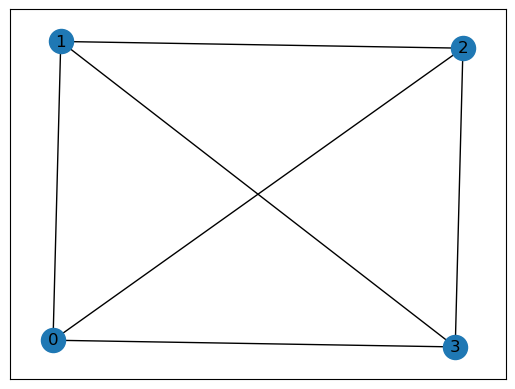

In [13]:
#Create the graph
G = FileToNetwork("graph3.txt")
DrawNetwork(G, "3.png")

In [14]:
#Parameters
min_tf = 0.5
max_tf = 6.5
num_tf = 10
tf = np.linspace(min_tf, max_tf, num_tf)
delta_t = 0.001
print(tf)

[0.5        1.16666667 1.83333333 2.5        3.16666667 3.83333333
 4.5        5.16666667 5.83333333 6.5       ]


In [15]:
#Functions
A, B = path("DW_2000Q_6.txt")

In [16]:
#Hamiltonians
Hi = makeInitialHamiltonian(len(list(G.nodes)))
Hp1, Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
gs = groundState(Hp1)
num_eigenstates = 6
dim = len(Hi)
print(gs)

[3, 5, 6, 9, 10, 12]


In [17]:
#Evolution of the energy
gap, energies = spectraEvolution(Hi, Hp2, A, B, 100, num_eigenstates, gs)
print(gap)

4.681656232080746


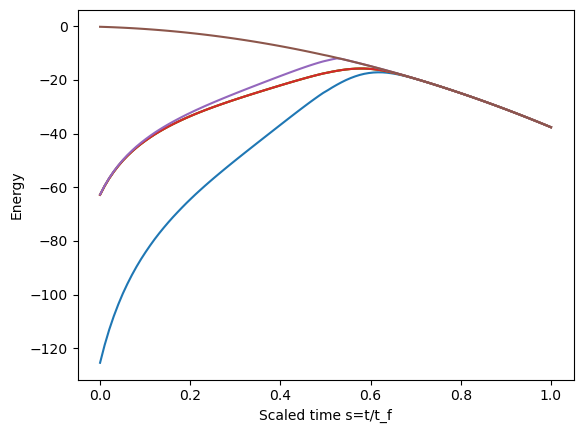

In [18]:
for i in range(num_eigenstates):
    plt.xlabel("Scaled time s=t/t_f")
    plt.ylabel("Energy")
    plt.plot(np.linspace(0,1,100), energies[i])

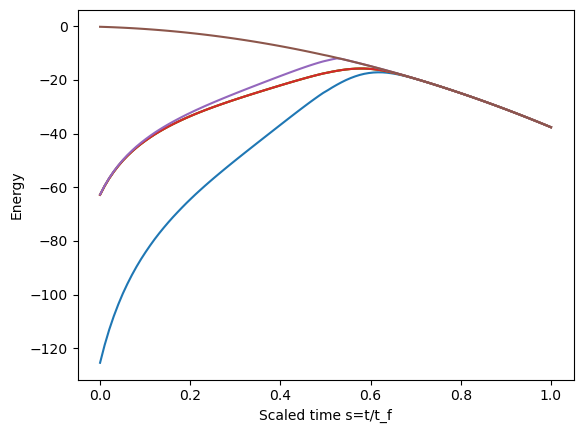

In [19]:
for i in range(len(gs)):
    plt.xlabel("Scaled time s=t/t_f")
    plt.ylabel("Energy")
    plt.plot(np.linspace(0,1,100), energies[i])

In [20]:
#Overlap (instantaneous ground state)
overlap_IG = []
for i in range(num_tf):
    overlap_IG.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_IG[i].append(evolutionAB_IG(Hi, Hp2, A, B, t_f, delta_t, gs)) 

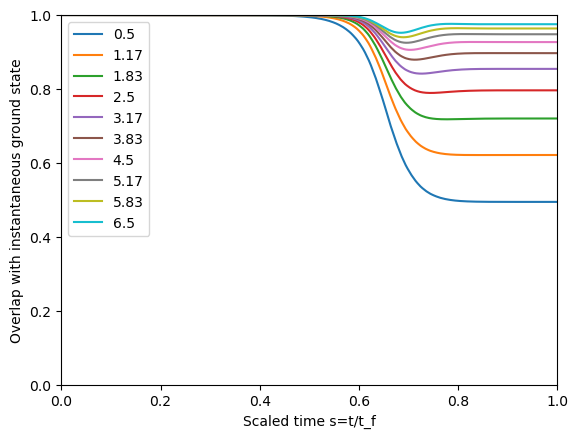

In [21]:
#Plot overlap with instantaneous ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with instantaneous ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_IG[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_IG[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_IG_4.png")

In [20]:
#Overlap (target ground state)
overlap_TG = []
for i in range(num_tf):
    overlap_TG.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_TG[i].append(evolutionABTarget(Hi, Hp2, A, B, t_f, delta_t, gs)) 

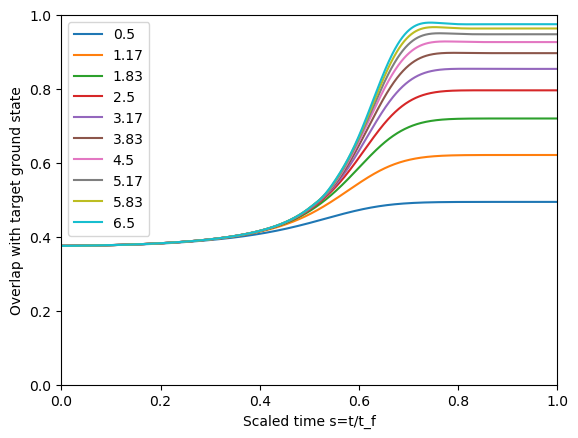

In [21]:
#Plot overlap with target ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with target ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_TG[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_TG[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_TG_4.png")

In [24]:
def checkResults(overlap1, overlap2, num_tf):
    results = []
    
    for i in range(num_tf):
        results.append(overlap1[i][0][-1]-overlap2[i][0][-1])
    return results           

In [25]:
print(checkResults(overlap_IG, overlap_TG, num_tf))

[3.834265027702344e-08, -2.1568024555218557e-07, -5.971091066037104e-09, 1.7690127751546214e-07, 1.2972889207318872e-08, -1.3300687384809606e-07, -1.898001822375761e-08, 9.590865435171736e-08, 1.895126977569106e-08, -6.647815753435538e-08]


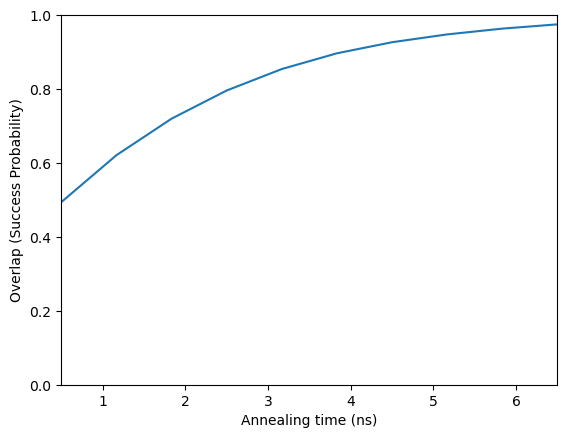

In [22]:
plt.xlim([min(tf), max(tf)])
plt.ylim([0, 1])
plt.xlabel("Annealing time (ns)")
plt.ylabel("Overlap (Success Probability)")
successProbability = np.empty(num_tf)
for i in range(num_tf):
    successProbability[i] = overlap_TG[i][0][-1]
plt.plot(tf, successProbability)
plt.savefig("Success_Probability_vs_Annealing_time_4.png")

## Simulation for a given graph (physical system)

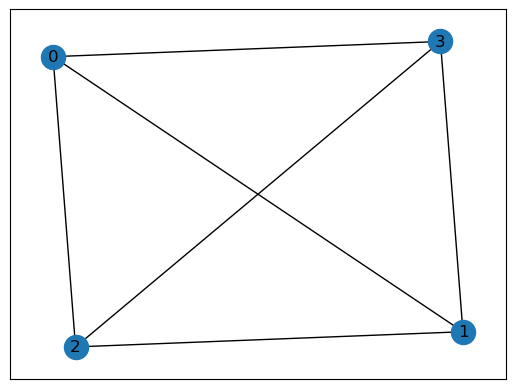

In [13]:
#Create the graph
G = FileToNetwork("graph3.txt")
DrawNetwork(G, "3.png")
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)

In [14]:
#Parameters
min_RCS = 0.0
max_RCS = 2.0
num_RCS = 100
RCS = np.linspace(min_RCS, max_RCS, num_RCS)
min_tf = 0.5
max_tf = 6.5
num_tf =10
tf = np.linspace(min_tf, max_tf, num_tf)
delta_t = 0.001
print(tf)

[0.5        1.16666667 1.83333333 2.5        3.16666667 3.83333333
 4.5        5.16666667 5.83333333 6.5       ]


In [15]:
#Embedding
C = FileToNetwork("chimera.txt")
#embedding = mm.find_embedding(G, C)
embedding = {1: [1779], 0: [1777, 1783], 3: [1776, 1781], 2: [1780]}
num_physical_qubits = 0
for i in range(len(embedding)):
    num_physical_qubits += len(embedding[i])
print(num_physical_qubits)

6


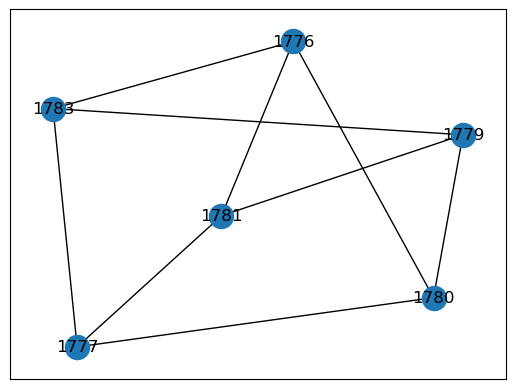

[1776, 1777, 1779, 1780, 1781, 1783]
[(1776, 1780), (1776, 1781), (1776, 1783), (1777, 1780), (1777, 1781), (1777, 1783), (1779, 1780), (1779, 1781), (1779, 1783)]


In [16]:
physical_nodes = []
for vertex in embedding:
    for node in embedding[vertex]:
        physical_nodes.append(node)
#physical_nodes.sort()
    
used_graph = C.subgraph(physical_nodes) 
DrawNetwork(used_graph, "embedding.png")
print(list(used_graph.nodes))
print(list(used_graph.edges))

In [17]:
#Functions
A, B = path("DW_2000Q_6.txt")

In [18]:
#Hamiltonians
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
gs = groundState(logical_Hp1)
num_eigenstates = 6
print(gs)

[3, 5, 6, 9, 10, 12]


In [ ]:
#Overlap (instantaneous ground state RCS = 0.2)

physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, 0.2)
physical_Hi = makeInitialHamiltonian(num_physical_qubits)
gs = groundState(physical_Hp1)

overlap_IG_physical = []
for i in range(num_tf):
    overlap_IG_physical.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_IG_physical[i].append(evolutionAB_IG(physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs)) 

In [ ]:
#Plot overlap with instantaneous ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with instantaneous ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_IG_physical[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_IG_physical[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_IG(physical)_4.png")

In [ ]:
#Overlap (target ground state RCS = 0.2)

physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, 0.2)
physical_Hi = makeInitialHamiltonian(num_physical_qubits)
gs = groundState(physical_Hp1)

overlap_TG_physical = []
for i in range(num_tf):
    overlap_TG_physical.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_TG_physical[i].append(evolutionABTarget(physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs)) 

In [ ]:
#Plot overlap with target ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with target ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_TG_physical[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_TG_physical[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_TG(physical)_4.png")

In [49]:
print(checkResults(overlap_IG_physical, overlap_TG_physical, num_tf))

[1.2328036064213066e-08, -4.5088822397953976e-08, 2.4270651155511302e-08, -8.344354096578854e-09, -3.1881583262283186e-08]


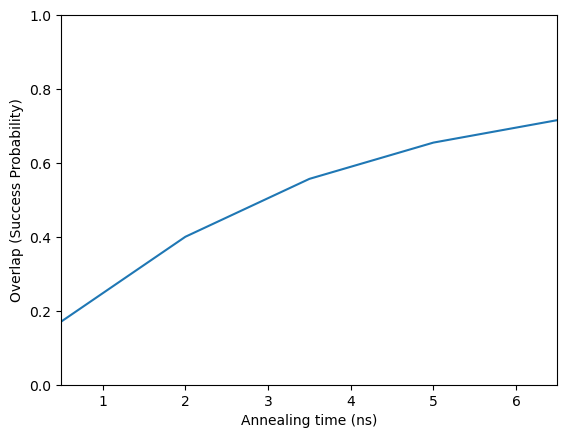

In [21]:
plt.xlim([min(tf), max(tf)])
plt.ylim([0, 1])
plt.xlabel("Annealing time (ns)")
plt.ylabel("Overlap (Success Probability)")
successProbability_physical = np.empty(num_tf)
for i in range(num_tf):
    successProbability_physical[i] = overlap_TG_physical[i][0][-1]
plt.plot(tf, successProbability_physica)
plt.savefig("Success_Probability_vs_Annealing_time_4(physical).png")

In [22]:
success = []
for i in range(num_tf):
    success.append([])
for i in range(num_RCS):
    physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, RCS[i])
    physical_Hi = makeInitialHamiltonian(num_physical_qubits)
    gs = groundState(physical_Hp1)
    
    for j in range(num_tf):
        t_f = tf[j]
        success[j].append(evolutionABTargetFinal(physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs))

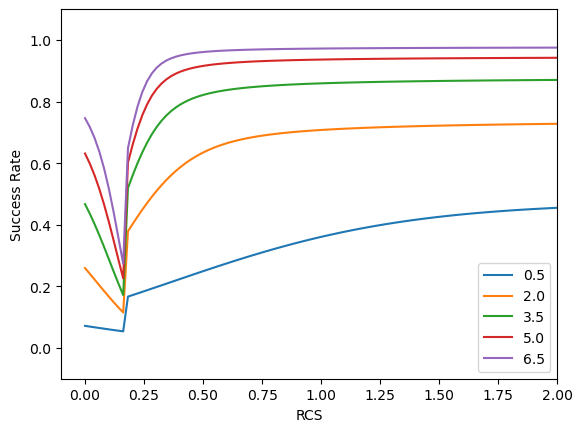

In [23]:
plt.xlim([-0.1, max(RCS)])
plt.ylim([-0.1, 1.1])
plt.xlabel("RCS")
plt.ylabel("Success Rate")
for i in range(num_tf):
    name = str(round(tf[i],2))
    plt.plot(RCS, success[i], label = name)
    plt.legend()
plt.savefig("Success_Probability_vs_RCS_4.png")

In [19]:
min_RCS = 0.0
max_RCS = 1.0
num_RCS = 20
RCS = np.linspace(min_RCS, max_RCS, num_RCS)

num_RCS2 =100
RCS2 = np.linspace(min_RCS, max_RCS, num_RCS2)

success = []

for i in range(num_RCS2):
    physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, RCS2[i])
    physical_Hi = makeInitialHamiltonian(num_physical_qubits)
    gs = groundState(physical_Hp1)

    success.append(evolutionABTargetFinal(physical_Hi, physical_Hp2, A, B, 8.5, delta_t, gs))

cut_edges_DW = np.empty(num_RCS)
success_rate = np.zeros(num_RCS)
deviation = np.zeros(num_RCS)

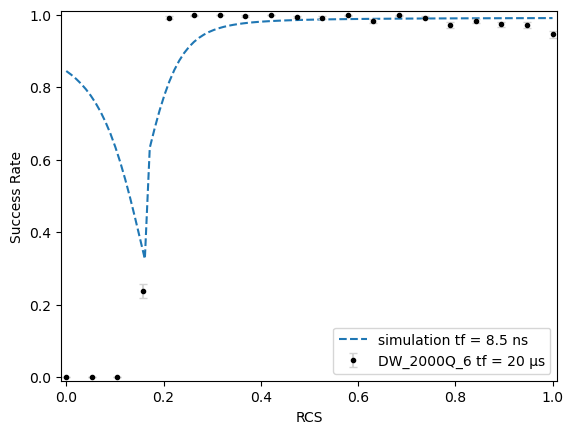

In [20]:
with open("DW-RCS-graph3.txt") as file:
    i = 0
    for line in file:
        info = line.split()
        success_rate[i] = float(info[1])
        deviation[i] = float(info[2])
        cut_edges_DW[i] = float(info[3])
        i += 1
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
plt.xlabel("RCS")
plt.ylabel("Success Rate")
plt.plot(RCS2, success, '--', label = "simulation tf = 8.5 ns")
plt.errorbar(RCS, success_rate, yerr = deviation, fmt='.', color='black', ecolor='lightgray', capsize = 3, label = "DW_2000Q_6 tf = 20 μs")
plt.legend()
plt.savefig("Success_Rate_vs_RCS(DW+sim)_8_5.png")